In [8]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

from notebooks.utils import display

In [10]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [11]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [12]:
# 데이터 전처리
def preprocess(imgs):
    """
    이미지 정규화 및 크기 변경
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

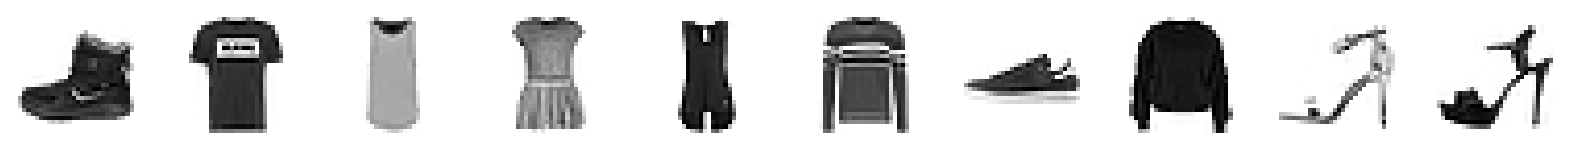

In [13]:
# 훈련 세트의 일부 의류 항목 표시
display(x_train)

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

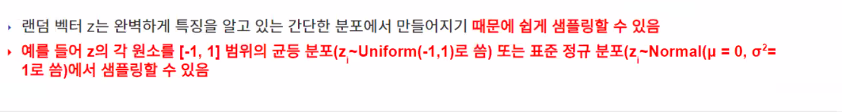

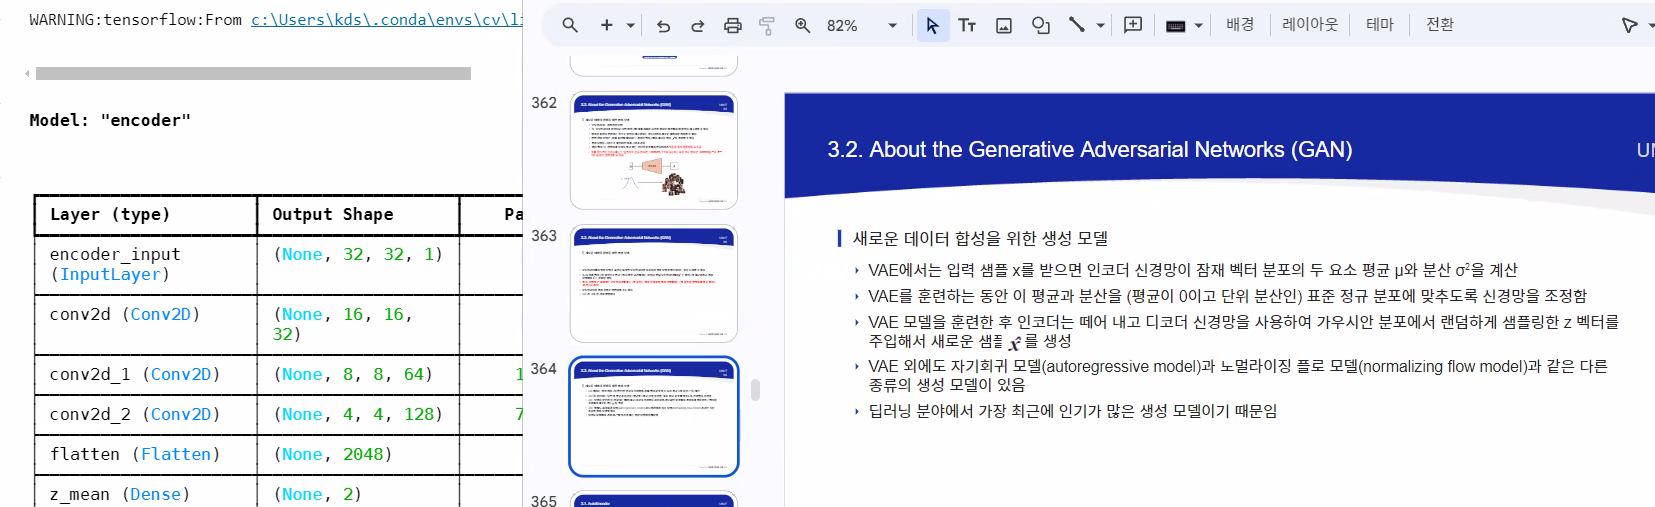

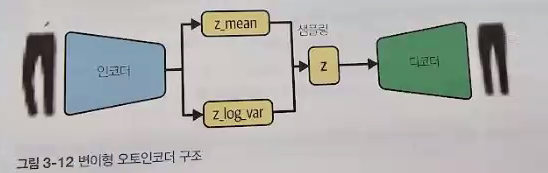

In [22]:

# 인코더
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요합니다!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_4 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_4[0][0]']               
                                                                                            

In [15]:
# 디코더
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464 

In [16]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """특정 입력에서 모델을 호출합니다."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """훈련 스텝을 실행합니다."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def get_config(self):
        return {}

In [17]:
# 변이형 오토인코더 생성
vae = VAE(encoder, decoder)

## 변이형 오토인코더 훈련

In [18]:
# 변이형 오토인코더 컴파일
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [19]:
# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [20]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 [==============================] - 87s 142ms/step - total_loss: 160.9167 - reconstruction_loss: 156.4481 - kl_loss: 4.4687 - val_loss: 140.3445 - val_reconstruction_loss: 135.4546 - val_kl_loss: 4.8899
Epoch 2/5
600/600 [==============================] - 88s 147ms/step - total_loss: 135.8546 - reconstruction_loss: 130.8944 - kl_loss: 4.9602 - val_loss: 137.9075 - val_reconstruction_loss: 132.7887 - val_kl_loss: 5.1188
Epoch 3/5
600/600 [==============================] - 86s 144ms/step - total_loss: 134.0654 - reconstruction_loss: 129.0568 - kl_loss: 5.0088 - val_loss: 136.8721 - val_reconstruction_loss: 131.7361 - val_kl_loss: 5.1361
Epoch 4/5
600/600 [==============================] - 87s 145ms/step - total_loss: 133.1704 - reconstruction_loss: 128.1165 - kl_loss: 5.0540 - val_loss: 135.7867 - val_reconstruction_loss: 130.6508 - val_kl_loss: 5.1359
Epoch 5/5
600/600 [==============================] - 84s 139ms/step - total_loss: 132.5600 - reconstruction_loss: 127.48

In [25]:
# 최종 모델 저장
vae.save("./models/vae", save_traces=False)
encoder.save("./models/encoder" , save_traces=False)
decoder.save("./models/decoder" , save_traces=False)

INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/vae\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


### 3. 변이형 오토인코더를 사용한 재구성

In [26]:
# 테스트셋의 일부를 선택합니다.
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 3s 17ms/step
실제 의류 아이템


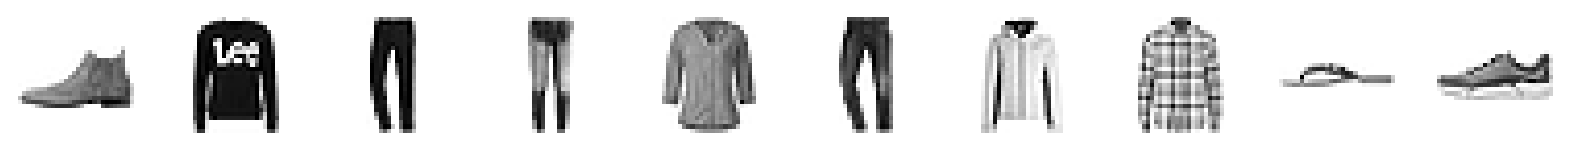

재구성 이미지


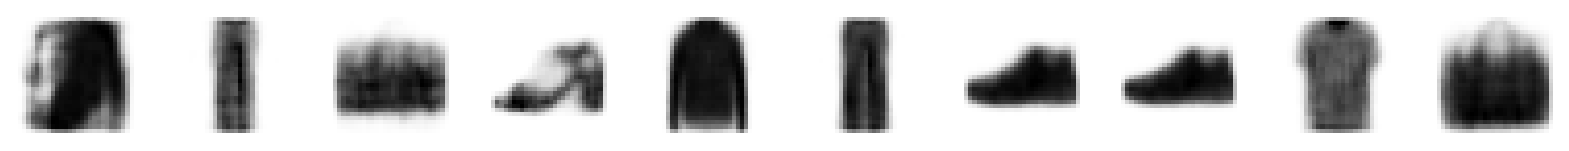

In [27]:
# 오토인코더 예측을 만들고 출력합니다.
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("실제 의류 아이템")
display(example_images)
print("재구성 이미지")
display(reconstructions)

### 4. 인코더를 사용하여 임베딩하기

In [28]:
# 예제 이미지 인코딩
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 1s 4ms/step


In [29]:
# 임베딩의 몇 가지 예
print(z[:10])

[[-0.09073746  1.5531268 ]
 [ 1.229439   -0.3679176 ]
 [ 2.5969737  -0.49431485]
 [-1.0457894   0.5379092 ]
 [ 0.18929039  0.09412475]
 [ 0.2283176  -1.4632436 ]
 [ 0.5287849   1.9792383 ]
 [ 1.4323562   0.21073726]
 [-2.089876    1.4969255 ]
 [-1.5565605   2.299012  ]]


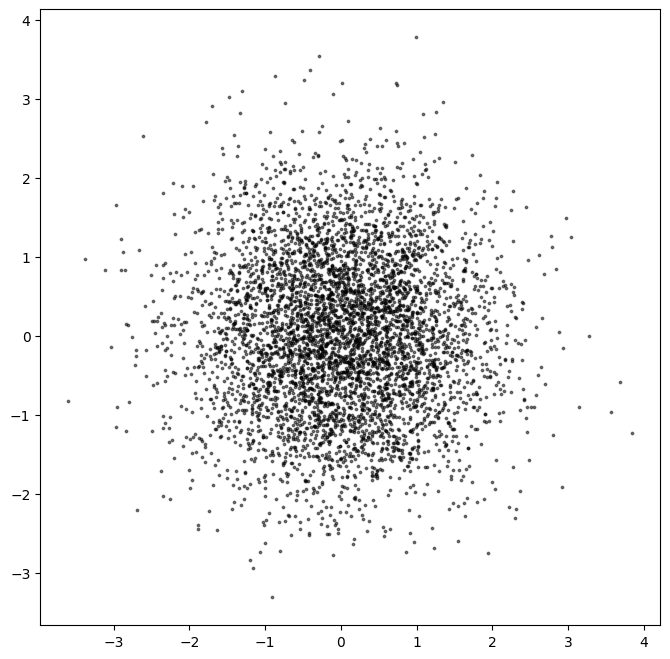

In [30]:
# 2D 공간에서 인코딩된 포인트 표시
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

### 5. 디코더를 사용하여 생성하기

In [31]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [32]:
# 샘플링된 포인트 디코딩
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 83ms/step


In [33]:
# 원본 임베딩과 샘플링된 임베딩을 p값으로 변환하기
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

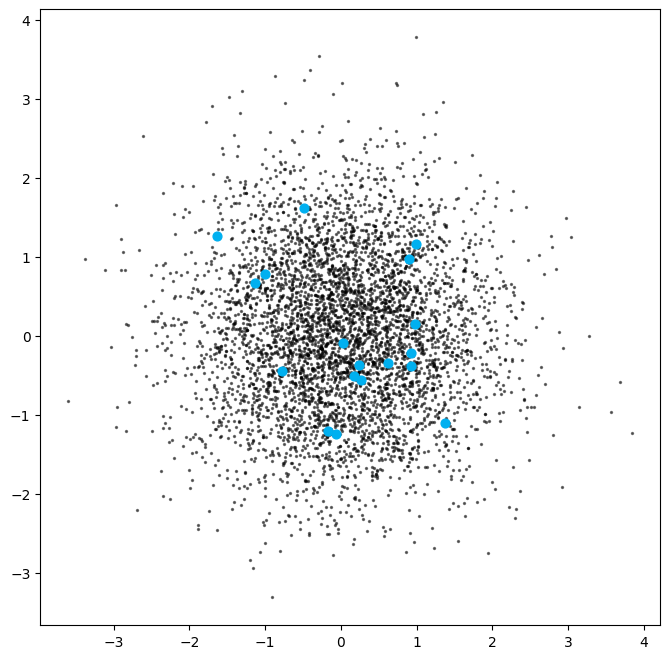

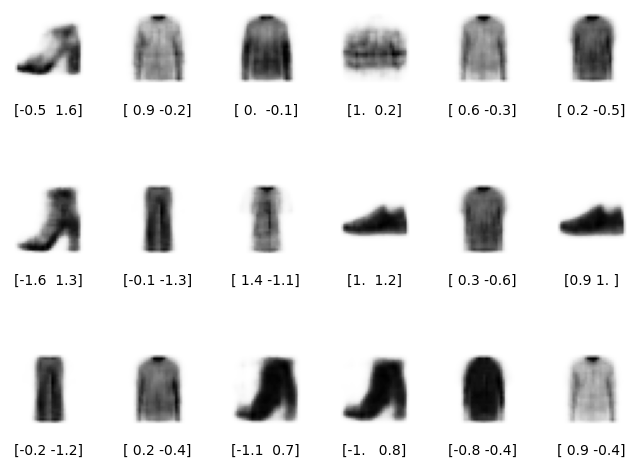

In [34]:
# 그래프를 그립니다....
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... 원본 임베딩 ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... 잠재 공간에 새로 생성된 포인트
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드를 추가합니다.
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

### 6. 잠재 공간 탐색

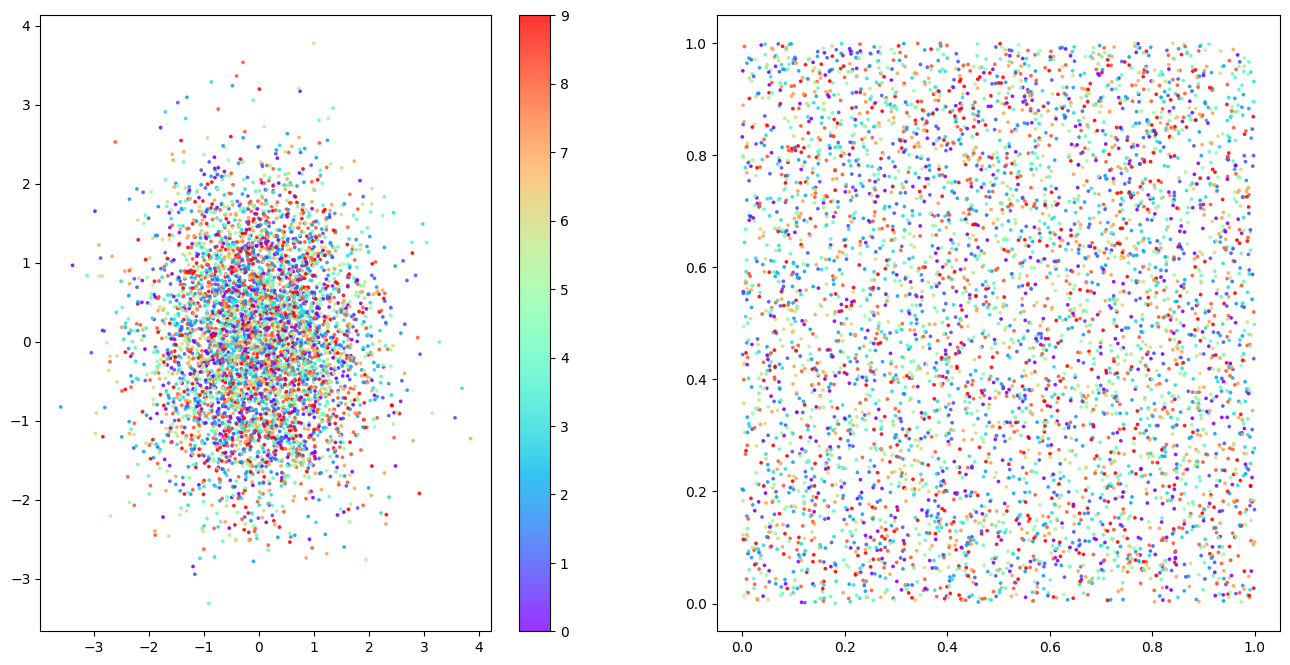

In [35]:
# 레이블(의류 종류)에 따라 임베딩에 색상을 지정합니다.
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 14ms/step


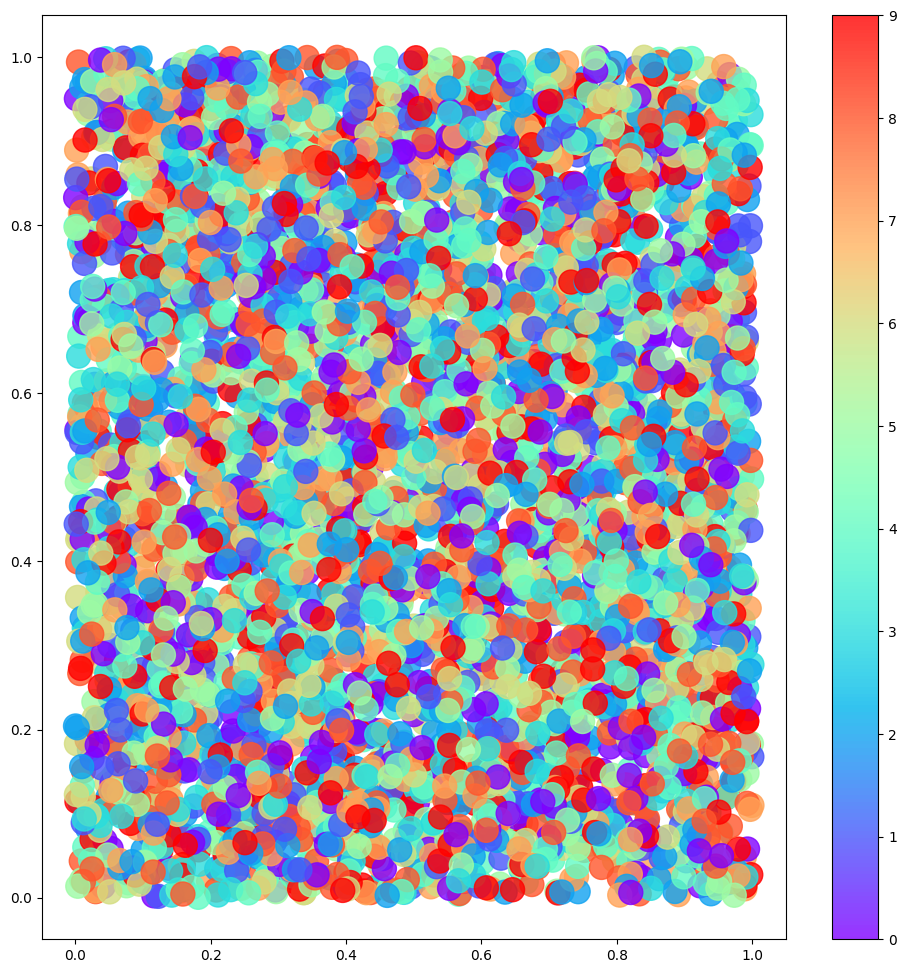

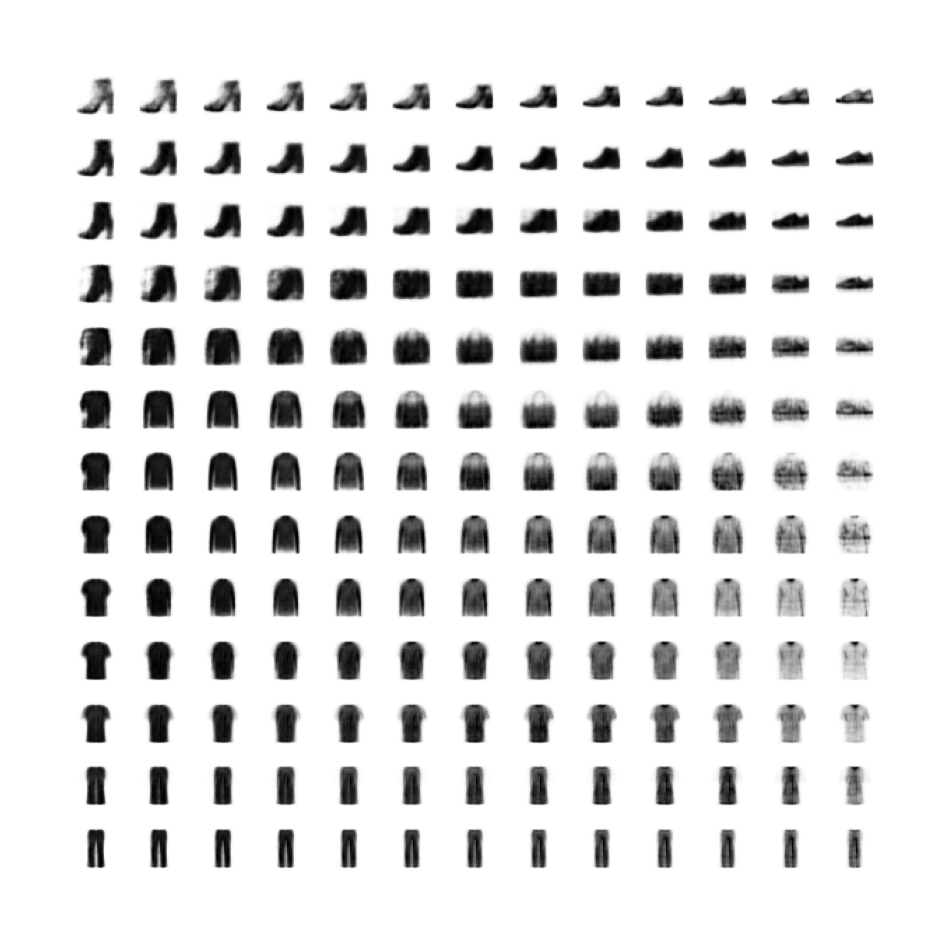

In [36]:
# 레이블(의류 종류)에 따라 임베딩에 색상을 지정합니다.
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")